In [69]:
import os
import sys
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, auc, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
# import tensorflow as tf
#import keras_metrics as km


#Keras import
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dropout, Dense, Input, Concatenate, Multiply, Embedding, Activation, Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras.initializers import RandomUniform
from sklearn.decomposition import PCA

In [30]:
data_path = "KGE"
dim1 = 20
dim2 = 20
alpha = 0

In [31]:
def read_ids(path):
    ids = {}
    
    with open(path) as file:
        for line in file:
            line = line.split("\t")
            ids.update({line[0]:int(line[1])})
    print(path+"\t"+ str(len(ids)))
    return ids

In [32]:
def read_triplets(path, e_id, r_id):
    s_data = []
    o_data = []
    p_data = []
    
    with open(path) as file:
        for line in file:
            line = line.replace('\n', '').split("\t")
            s_data.append( e_id[line[0]] )
            o_data.append( e_id[line[1]] )
            p_data.append( r_id[line[2]] )
            
    print(path+"\t"+ str(len(s_data)))
    return np.array(s_data),np.array(o_data),np.array(p_data)

In [61]:
e_id = read_ids("data/"+data_path+"/entity2id.txt")
r_id = read_ids("data/"+data_path+"/relation2id.txt")
s_test,o_test,p_test = read_triplets("data/"+data_path+"/test.txt", e_id, r_id)
s_train,o_train,p_train = read_triplets("data/"+data_path+"/train.txt", e_id, r_id)
#s_valid,o_valid,p_valid = read_triplets("data/"+data_path+"/valid.txt", e_id, r_id)
s_kgc,o_kgc,p_kgc = read_triplets("data/"+data_path+"/kgc.txt", e_id, r_id)

# for test purposes
#s_all = np.concatenate((s_test,s_train,s_valid))
#o_all = np.concatenate((o_test,o_train,o_valid))
#p_all = np.concatenate((p_test,p_train,p_valid))

data/KGE/entity2id.txt	553
data/KGE/relation2id.txt	77
data/KGE/test.txt	132
data/KGE/train.txt	525
data/KGE/kgc.txt	657


In [34]:
def combine(s_data, o_data, p_data, sources, e_id, r_id):
    so2p = {}
    sp2o = {}
    op2s = {}
    for source in sources:
        s_source = source[0]
        o_source = source[1]
        p_source = source[2]
        so2p = count_pair(s_source,o_source,p_source,so2p)
        sp2o = count_pair(s_source,p_source,o_source,sp2o)
        op2s = count_pair(o_source,p_source,s_source,op2s)
        
    s_combine = np.zeros((len(s_data),len(e_id)), dtype = bool)
    o_combine = np.zeros((len(o_data),len(e_id)), dtype = bool)
    p_combine = np.zeros((len(p_data),len(r_id)), dtype = bool)
    
    for s,o,p,i in zip(s_data,o_data,p_data,range(len(s_data))):
        s_combine[i][list(op2s[(o,p)])] = True
        o_combine[i][list(sp2o[(s,p)])] = True
        p_combine[i][list(so2p[(s,o)])] = True
        
    print(s_combine.sum()/(len(s_data)*len(e_id)))
    print(o_combine.sum()/(len(o_data)*len(e_id)))
    print(p_combine.sum()/(len(p_data)*len(r_id)))
    return s_combine,o_combine,p_combine

In [35]:
def count_pair(A,B,C,p2i):
    for a,b,c in zip(A,B,C):
        if (a,b) not in p2i:
            p2i.update({(a,b):set()})
        p2i[(a,b)].add(c)
    return p2i

In [36]:
s_train_comb,o_train_comb,p_train_comb = combine(s_train,o_train,p_train,[[s_train,o_train,p_train]], e_id, r_id)
s_test_comb,o_test_comb,p_test_comb = combine(s_test,o_test,p_test,[[s_train,o_train,p_train],[s_test,o_test,p_test]], e_id, r_id)
#s_test_comb,o_test_comb,p_test_comb = combine(s_test,o_test,p_test,[[s_train,o_train,p_train],[s_test,o_test,p_test],[s_valid,o_valid,p_valid]], e_id, r_id)
#s_kgc_comb,o_kgc_comb,p_kgc_comb = combine(s_kgc,o_kgc,p_kgc,[[s_train,o_train,p_train],[s_test,o_test,p_test],[s_valid,o_valid,p_valid]], e_id, r_id)


ent_voc = len(e_id)
rel_voc = len(r_id)

0.004295186429001981
0.007929045035735813
0.016722325293753865
0.0044796975176722015
0.009137486985588252
0.015545060999606454


In [37]:
ent_voc

553

In [38]:
def dynamic_weighted_binary_crossentropy(l,alpha=0.5):
    
    def loss(y_true, y_pred):
        w_neg = K.sum(y_true) / l
        w_pos = 1 - w_neg
        r = 2*w_neg*w_pos
        w_neg /= r
        w_pos /= r
        
        b_ce = K.binary_crossentropy(y_true, y_pred)
        w_b_ce = b_ce *y_true* w_pos + b_ce * (1-y_true) * w_neg 
        return K.mean(w_b_ce) * alpha + K.mean(b_ce) * (1-alpha)
    
    return loss

In [39]:
def P(y_true, y_pred):
    true_positives = K.sum(K.cast_to_floatx(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20)))
    pred_positives = K.sum(K.cast_to_floatx(K.greater(K.clip(y_pred, 0, 1), 0.50)))

    precision = true_positives / (pred_positives + K.epsilon())
    return precision

In [40]:
def R(y_true, y_pred):
    true_positives = K.sum(K.cast_to_floatx(K.greater(K.clip(y_true * y_pred, 0, 1), 0.20)))
    poss_positives = K.sum(K.cast_to_floatx(K.greater(K.clip(y_true, 0, 1), 0.50)))

    recall = true_positives / (poss_positives + K.epsilon())
    return recall

In [41]:
def hit_count_pair(x_data, y_data, z_data):
    xy2z = {}
    for x,y,z in zip(x_data, y_data, z_data):
        if (x,y) not in xy2z:
            xy2z.update({(x,y):set()})
        xy2z[(x,y)].add(z)
    return xy2z

In [42]:
def hits(inputs1, inputs2, preds, trues, k = 1, th = 0.5):
    i2p = hit_count_pair(s_all,o_all,p_all)
    hits_k_raw = 0.
    hits_k_filt = 0.
    hits_pos = 0.
    
    for i1, i2, pred, true in zip(inputs1, inputs2, preds, trues):
        for p in np.argsort(pred)[::-1][:k]:
            if p == true:
                hits_k_raw += 1
                break
        
        count = 0
        for p in np.argsort(pred)[::-1]:
            if p == true:
                hits_k_filt += 1
                break
            if (i1,i2) in i2p:
                if p in i2p[(i1,i2)]:
                    continue
            count += 1
            if count >= k:
                break
            
        if pred[true] >= th:
            hits_pos += 1
            
    hits_k_raw /= len(inputs1)
    hits_k_filt /= len(inputs1)
    hits_pos /= len(inputs1)
    
    print("hits@"+str(k)+" raw:\t" + str(hits_k_raw))
    print("hits@"+str(k)+" filt:\t" + str(hits_k_filt))
    print("hits@positive:\t" + str(hits_pos))

In [43]:
def ROC(preds, trues, th = 0.5):
    acc = 0.
    auc = 0.
    precision = 0.
    recall = 0.
    f1 = 0.
    
    count = 0
    
    for pred, true in zip(preds, trues):
        count += 1
        auc += roc_auc_score(true, pred)
    
        pred = pred > th
        if pred.sum() == 0:
            continue
            
        acc += accuracy_score(true,pred)
        pre = precision_score(true, pred, average='binary')  
        rec = recall_score(true, pred, average='binary') 
        precision += pre
        recall += rec
        if (pre+rec) > 0:
            f1 += 2*pre*rec /(pre+rec)
    
    acc /= count
    auc /= count
    precision /= count
    recall /= count
    f1 /= count
    
    print("Accuracy:\t" + str(acc))
    print("AUC:     \t" + str(auc))
    print("P:       \t" + str(precision))
    print("R:       \t" + str(recall))
    print("F1:     \t" + str(f1))

In [44]:
def learning_rate(epoch):
    if epoch > 40:   return 0.00001
    elif epoch > 30: return 0.000033
    elif epoch > 20: return 0.0001
    elif epoch > 10: return 0.00033
    return 0.001

In [45]:
sample_weight = np.zeros((len(s_train),))
so2p = count_pair(s_train,o_train,p_train,{})
for s,o,i in zip(s_train, o_train,range(len(s_train))):
    sample_weight[i] = 1/ len(so2p[(s,o)])
sample_weight /= sample_weight.sum()/len(s_train)
del so2p

In [46]:
S_input = Input(shape=(1,), dtype="int32", name="S_input")
O_input = Input(shape=(1,), dtype="int32", name="O_input")

In [47]:
embed_layer = Embedding(ent_voc, dim1)
S_embed = embed_layer(S_input)
O_embed = embed_layer(O_input)

In [48]:
reshape_layer = Reshape((dim1,), input_shape=(1,dim1))
S_reshape = reshape_layer(S_embed)
O_reshape = reshape_layer(O_embed)

In [49]:
SO_merged = Multiply()([S_reshape, O_reshape])
SO_merged = Concatenate()([S_reshape, O_reshape,SO_merged])

In [50]:
SO_merged = Dropout(0.3)(SO_merged)
SO_merged = Dense(int(dim2*1.5), activation="relu")(SO_merged)
SO_merged = Dropout(0.1)(SO_merged)
SO_merged = Dense(int(dim2*1.5/2), activation="relu")(SO_merged)
SO_merged = Dropout(0.1)(SO_merged)

In [51]:
P_pred = Dense(rel_voc, activation="sigmoid")(SO_merged)

In [52]:
model = Model([S_input, O_input], P_pred)

In [53]:
lr_cb = LearningRateScheduler(learning_rate)

In [388]:
model.compile(optimizer="adam", loss=dynamic_weighted_binary_crossentropy(rel_voc,alpha=alpha), 
              metrics=["binary_accuracy",P,R])

In [403]:
model.fit([s_train, o_train], K.cast_to_floatx(p_train_comb), epochs=20, \
          sample_weight=sample_weight, callbacks=[lr_cb])

Epoch 1/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0673 - binary_accuracy: 0.9839 - P: 3.7500 - R: 0.1762
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0675 - binary_accuracy: 0.9841 - P: 4117649.0000 - R: 0.1570
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0665 - binary_accuracy: 0.9843 - P: 1764708.1250 - R: 0.1707
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0665 - binary_accuracy: 0.9844 - P: 2.5613 - R: 0.1722
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0658 - binary_accuracy: 0.9847 - P: 1.5072 - R: 0.1746
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0652 - binary_accuracy: 0.9848 - P: 1764707.2500 - R: 0.1933
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0646 - binary_accuracy: 0.9852 - P: 1.6192 - R: 0.1865
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 0.0646 

In [404]:
# Save model in HDF5 format
model.save('KGML_model.h5')

In [54]:
my_functions = {
    "loss": dynamic_weighted_binary_crossentropy(len(r_id)),
    "P": P,
    "R": R
}

In [55]:
# Load model
kgml_model = load_model('KGML_model.h5', custom_objects=my_functions)

In [56]:
# Test model
p_preds = kgml_model.predict([s_test, o_test])

In [62]:
#hits(s_test,o_test,p_preds,p_test)
#hits(s_test,o_test,p_preds,p_test,k=10)

In [63]:
ROC(p_preds,K.cast_to_floatx(p_test_comb))    

Accuracy:	0.13547815820543094
AUC:     	0.797663440952915
P:       	0.10606060606060606
R:       	0.10606060606060606
F1:     	0.10606060606060606


In [64]:
# Get KG embeddings
kgml_emb = kgml_model.predict([s_kgc,o_kgc])

In [94]:
# Project embeddings into 2D space via PCA
kgml_pca = PCA(n_components=2)
kgml_emb_2d = kgml_pca.fit_transform(kgml_emb)

In [95]:
kgml_pca.explained_variance_ratio_

array([0.8607943 , 0.10884243], dtype=float32)

In [93]:
kgml_emb_2d[:5,]

array([[-0.10747952, -0.06425723],
       [-0.18702695, -0.03276301],
       [-0.16199276,  0.6592049 ],
       [-0.09257086, -0.10800052],
       [-0.13844594,  0.06614693]], dtype=float32)

In [87]:
kgml_emb_2d.explained_variance_ratio_

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

In [67]:
kg_embed = pd.DataFrame(kgml_emb_2d, columns = ['PC1', 'PC2'])

In [68]:
kg_embed.to_csv('./kgml_embedding.csv', index=False)

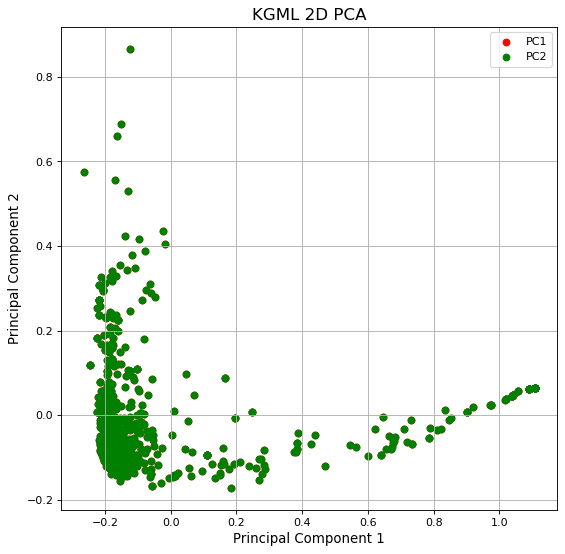

In [83]:
# PCA Plot
plt.figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

#classes = [1, 0]
colors = ['r', 'g']
for color in colors:
    plt.scatter(kg_embed['PC1'], 
                kg_embed['PC2'], 
                c = color)
    
plt.xlabel('Principal Component 1', fontsize = 12)
plt.ylabel('Principal Component 2', fontsize = 12)
plt.title('KGML 2D PCA', fontsize = 15)
plt.legend(['PC1', 'PC2'])
plt.grid()

In [70]:
?plt.scatter